# GENIE3

In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_perturb_gt

from bengrn.base import train_classifier

from bengrn import compute_genie3, compute_scenic
from grnndata import utils as grnutils
from anndata.utils import make_index_unique
import pandas as pd
import numpy as np

import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/bitsandbytes/cextension.py:31: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


💡 connected lamindb: jkobject/scprint


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [2]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()

/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gem_group' was written without encoding metadata.
  return func(*args, **kwargs)
/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/gene' was written without encoding metadata.
  return func(*args, **kwargs)
/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gene' was written without encoding metadata.
  return func(*args, **kwargs)
/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/gene_id' was written without encoding metadata.
  return func(*args, **kwargs)
/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/anndata/_io/uti

650

In [3]:
genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

#genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [4]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
NUM_GENES = 5000
NUM_CELLS = 1024
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 10691 renamining


filtered out 0 cells, 10691 renamining
Removed 8 genes.


startin QC


Seeing 10068 outliers (94.17% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [5]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:NUM_CELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
del subadata.varp['GRN']

In [6]:
metrics = {}

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 487.89 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.021411638790563244 
recall:  0.9659762797288713 
random precision: 0.020718126571001305



  0%|          | 0/128 [00:00<?, ?it/s]


  2%|▏         | 2/128 [00:00<00:06, 19.02it/s]


  4%|▍         | 5/128 [00:00<00:06, 19.82it/s]


  6%|▋         | 8/128 [00:00<00:06, 19.99it/s]


  9%|▊         | 11/128 [00:00<00:05, 20.19it/s]


 11%|█         | 14/128 [00:00<00:06, 18.32it/s]


 13%|█▎        | 17/128 [00:00<00:05, 19.00it/s]


 16%|█▌        | 20/128 [00:01<00:05, 19.46it/s]


 18%|█▊        | 23/128 [00:01<00:05, 19.75it/s]


 20%|██        | 26/128 [00:01<00:05, 19.95it/s]


 23%|██▎       | 29/128 [00:01<00:04, 20.04it/s]


 25%|██▌       | 32/128 [00:01<00:04, 20.06it/s]


 27%|██▋       | 35/128 [00:01<00:04, 20.14it/s]


 30%|██▉       | 38/128 [00:01<00:04, 20.17it/s]


 32%|███▏      | 41/128 [00:02<00:04, 20.17it/s]


 34%|███▍      | 44/128 [00:02<00:04, 20.14it/s]


 37%|███▋      | 47/128 [00:02<00:04, 20.18it/s]


 39%|███▉      | 50/128 [00:02<00:03, 20.09it/s]


 41%|████▏     | 53/128 [00:02<00:03, 20.08it/s]


 44%|████▍     | 56/128 [00:02<00:03, 20.15it/s]


 46%|████▌     | 59/128 [00:02<00:03, 20.18it/s]


 48%|████▊     | 62/128 [00:03<00:03, 20.25it/s]


 51%|█████     | 65/128 [00:03<00:03, 20.32it/s]


 53%|█████▎    | 68/128 [00:03<00:02, 20.34it/s]


 55%|█████▌    | 71/128 [00:03<00:02, 20.29it/s]


 58%|█████▊    | 74/128 [00:03<00:02, 20.27it/s]


 60%|██████    | 77/128 [00:03<00:02, 20.24it/s]


 62%|██████▎   | 80/128 [00:03<00:02, 20.18it/s]


 65%|██████▍   | 83/128 [00:04<00:02, 20.05it/s]


 67%|██████▋   | 86/128 [00:04<00:02, 20.09it/s]


 70%|██████▉   | 89/128 [00:04<00:01, 20.02it/s]


 72%|███████▏  | 92/128 [00:04<00:01, 19.98it/s]


 74%|███████▍  | 95/128 [00:04<00:01, 20.01it/s]


 77%|███████▋  | 98/128 [00:04<00:01, 20.05it/s]


 79%|███████▉  | 101/128 [00:05<00:01, 20.11it/s]


 81%|████████▏ | 104/128 [00:05<00:01, 20.16it/s]


 84%|████████▎ | 107/128 [00:05<00:01, 20.12it/s]


 86%|████████▌ | 110/128 [00:05<00:00, 20.22it/s]


 88%|████████▊ | 113/128 [00:05<00:00, 20.19it/s]


 91%|█████████ | 116/128 [00:05<00:00, 20.15it/s]


 93%|█████████▎| 119/128 [00:05<00:00, 20.24it/s]


 95%|█████████▌| 122/128 [00:06<00:00, 20.29it/s]


 98%|█████████▊| 125/128 [00:06<00:00, 20.33it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:06<00:00, 20.20it/s]


100%|██████████| 128/128 [00:06<00:00, 20.06it/s]

Area Under Precision-Recall Curve (AUPRC):  0.03565161597739377


EPR: 3.54075467253788


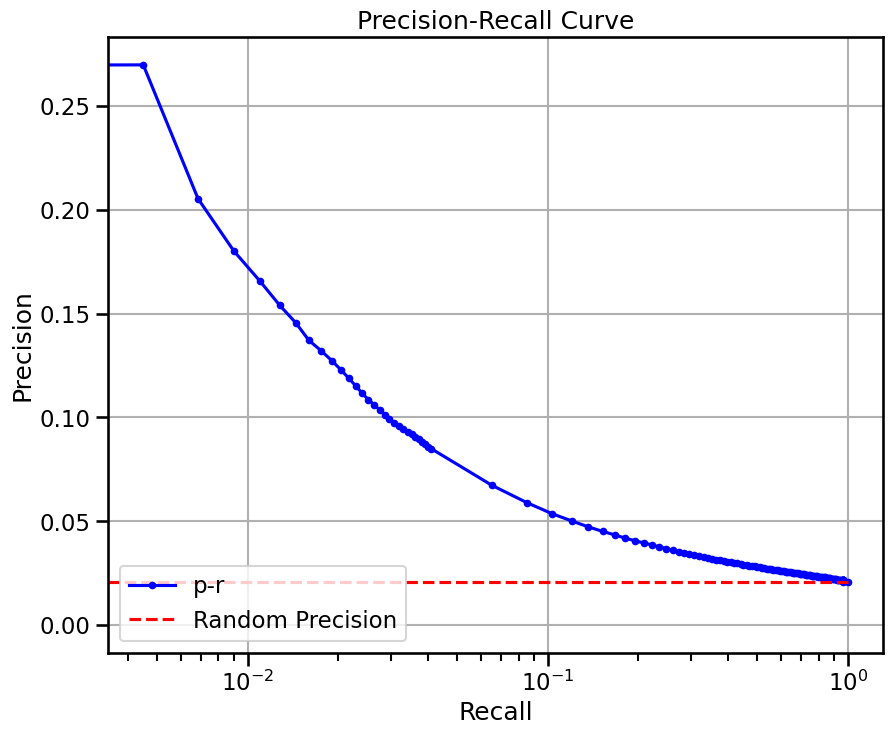

In [7]:
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var.index = subadata.var.index
metrics['genie3_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment


Top central genes: []


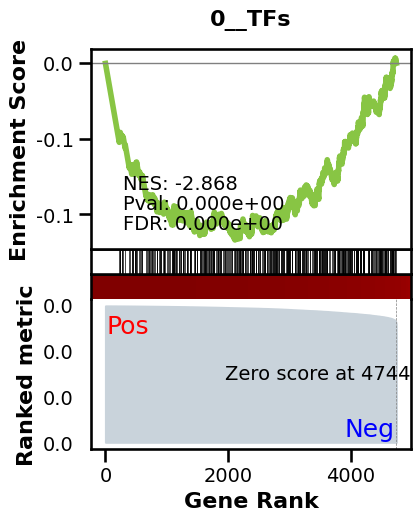

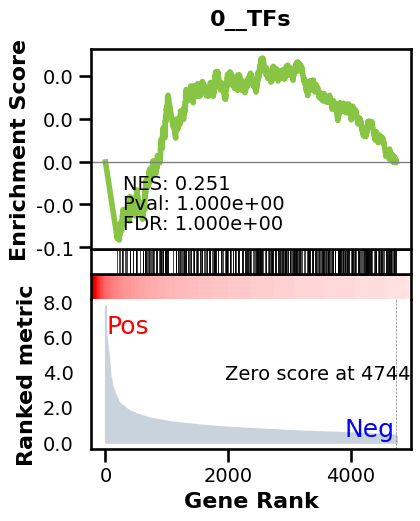

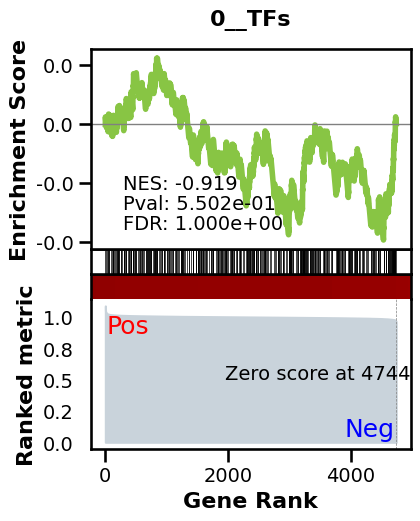

_________________________________________
TF specific enrichment


found some significant results for  19.642857142857142 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.0016940474499637448 
recall:  0.9264697414636955 
random precision: 0.0016326385571186594



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 52.02it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.76it/s]


 14%|█▍        | 18/128 [00:00<00:02, 51.60it/s]


 19%|█▉        | 24/128 [00:00<00:02, 51.93it/s]


 23%|██▎       | 30/128 [00:00<00:01, 52.10it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.94it/s]


 33%|███▎      | 42/128 [00:00<00:01, 51.98it/s]


 38%|███▊      | 48/128 [00:00<00:01, 52.02it/s]


 42%|████▏     | 54/128 [00:01<00:01, 52.05it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.93it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 52.18it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 52.27it/s]


 61%|██████    | 78/128 [00:01<00:00, 52.23it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 52.11it/s]


 70%|███████   | 90/128 [00:01<00:00, 52.13it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 52.03it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 51.68it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.70it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 51.76it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.76it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.82it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:02<00:00, 51.91it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0018857828449403108
EPR: 3.988476397763414


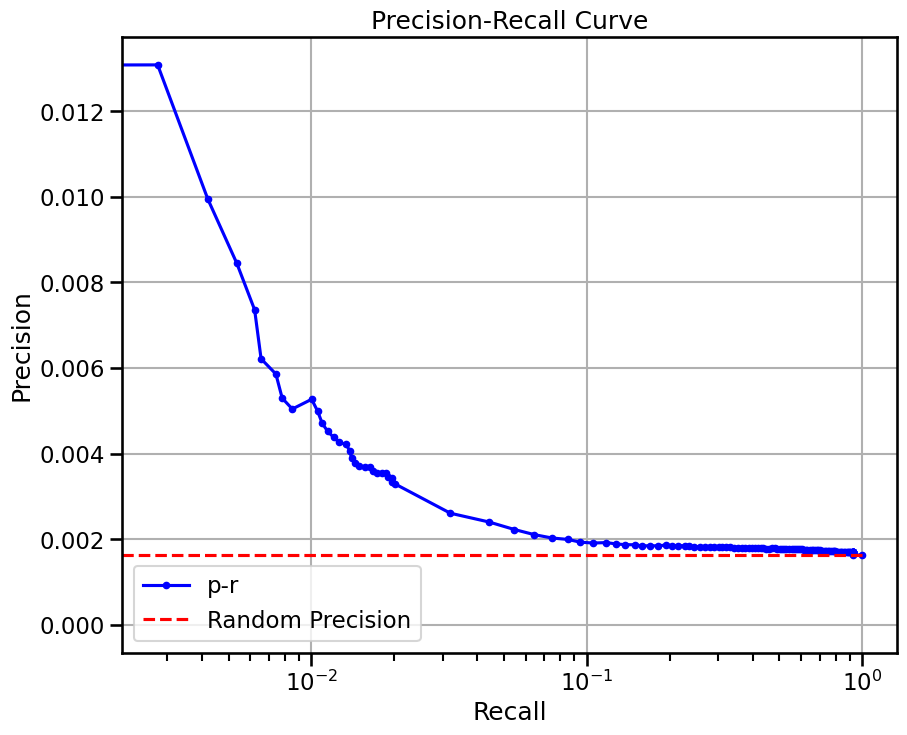

In [8]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
metrics['genie3_perturb_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 129.73 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.015117823033483179 
recall:  0.05607212414399698 
random precision: 0.020718126571001305



  0%|          | 0/128 [00:00<?, ?it/s]


  2%|▏         | 3/128 [00:00<00:06, 20.11it/s]


  5%|▍         | 6/128 [00:00<00:06, 20.02it/s]


  7%|▋         | 9/128 [00:00<00:05, 20.15it/s]


  9%|▉         | 12/128 [00:00<00:05, 20.10it/s]


 12%|█▏        | 15/128 [00:00<00:05, 20.15it/s]


 14%|█▍        | 18/128 [00:00<00:05, 20.16it/s]


 16%|█▋        | 21/128 [00:01<00:05, 20.02it/s]


 19%|█▉        | 24/128 [00:01<00:05, 20.00it/s]


 21%|██        | 27/128 [00:01<00:05, 19.94it/s]


 23%|██▎       | 29/128 [00:01<00:04, 19.84it/s]


 24%|██▍       | 31/128 [00:01<00:04, 19.75it/s]


 27%|██▋       | 34/128 [00:01<00:04, 19.78it/s]


 28%|██▊       | 36/128 [00:01<00:04, 19.78it/s]


 30%|███       | 39/128 [00:01<00:04, 19.89it/s]


 32%|███▏      | 41/128 [00:02<00:04, 19.91it/s]


 34%|███▍      | 44/128 [00:02<00:04, 19.98it/s]


 37%|███▋      | 47/128 [00:02<00:04, 20.08it/s]


 39%|███▉      | 50/128 [00:02<00:03, 20.11it/s]


 41%|████▏     | 53/128 [00:02<00:03, 20.13it/s]


 44%|████▍     | 56/128 [00:02<00:03, 20.15it/s]


 46%|████▌     | 59/128 [00:02<00:03, 20.10it/s]


 48%|████▊     | 62/128 [00:03<00:03, 20.07it/s]


 51%|█████     | 65/128 [00:03<00:03, 20.18it/s]


 53%|█████▎    | 68/128 [00:03<00:02, 20.12it/s]


 55%|█████▌    | 71/128 [00:03<00:02, 20.08it/s]


 58%|█████▊    | 74/128 [00:03<00:02, 20.04it/s]


 60%|██████    | 77/128 [00:03<00:02, 19.93it/s]


 62%|██████▏   | 79/128 [00:03<00:02, 19.80it/s]


 63%|██████▎   | 81/128 [00:04<00:02, 19.81it/s]


 66%|██████▌   | 84/128 [00:04<00:02, 19.86it/s]


 68%|██████▊   | 87/128 [00:04<00:02, 19.87it/s]


 70%|██████▉   | 89/128 [00:04<00:01, 19.68it/s]


 71%|███████   | 91/128 [00:04<00:01, 19.75it/s]


 73%|███████▎  | 94/128 [00:04<00:01, 19.94it/s]


 76%|███████▌  | 97/128 [00:04<00:01, 20.09it/s]


 78%|███████▊  | 100/128 [00:05<00:01, 20.15it/s]


 80%|████████  | 103/128 [00:05<00:01, 20.15it/s]


 83%|████████▎ | 106/128 [00:05<00:01, 20.15it/s]


 85%|████████▌ | 109/128 [00:05<00:00, 20.18it/s]


 88%|████████▊ | 112/128 [00:05<00:00, 20.20it/s]


 90%|████████▉ | 115/128 [00:05<00:00, 20.18it/s]


 92%|█████████▏| 118/128 [00:05<00:00, 20.17it/s]


 95%|█████████▍| 121/128 [00:06<00:00, 20.20it/s]


 97%|█████████▋| 124/128 [00:06<00:00, 20.20it/s]


 99%|█████████▉| 127/128 [00:06<00:00, 20.11it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████| 128/128 [00:06<00:00, 20.03it/s]

Area Under Precision-Recall Curve (AUPRC):  0.020825095462878654
EPR: 1.0667829823965929


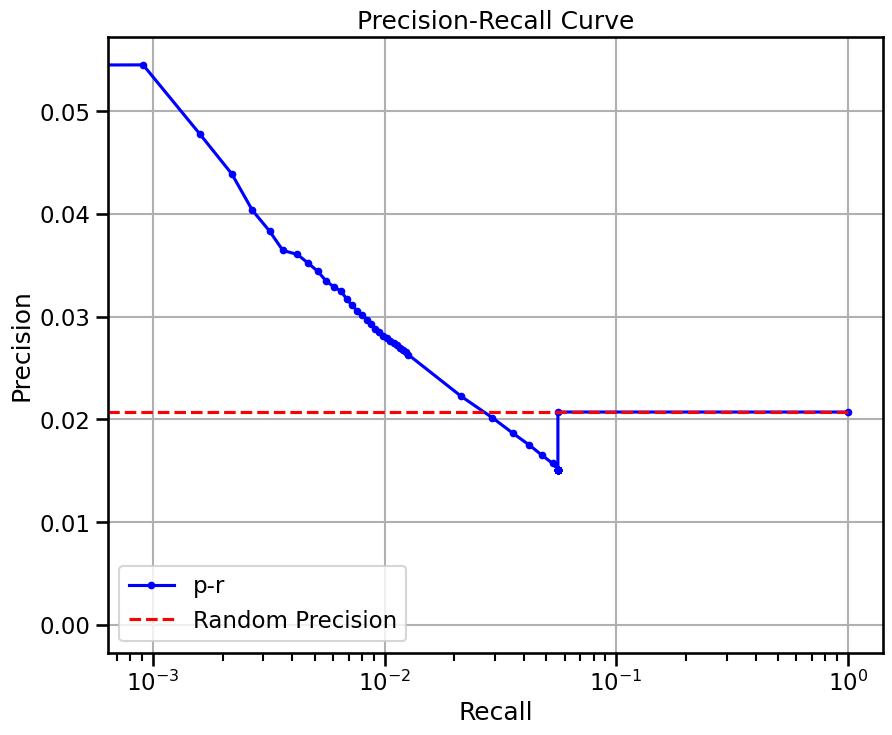

In [9]:
genie_grn = compute_genie3(subadata, nthreads=20,
                           regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var.index = subadata.var.index
metrics['genie3_tf_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment


Top central genes: []


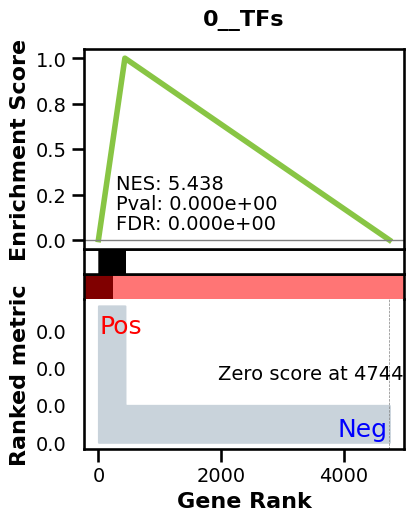

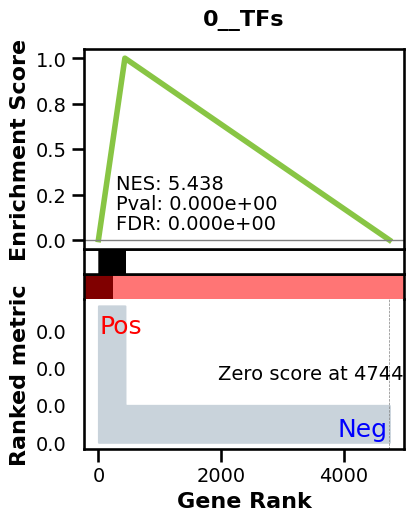

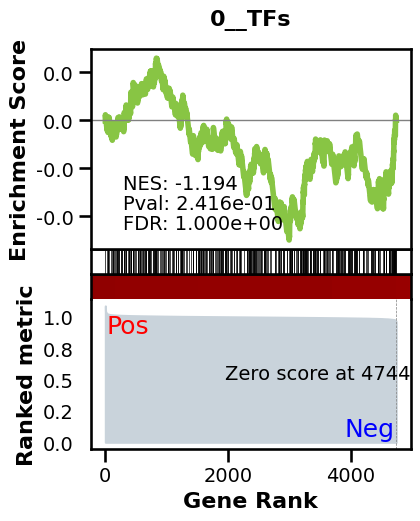

_________________________________________
TF specific enrichment


found some significant results for  5.357142857142857 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.008115454691164588 
recall:  0.5714285714285714 
random precision: 0.0016326385571186594



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.83it/s]


  9%|▉         | 12/128 [00:00<00:02, 52.28it/s]


 14%|█▍        | 18/128 [00:00<00:02, 52.44it/s]


 19%|█▉        | 24/128 [00:00<00:01, 52.47it/s]


 23%|██▎       | 30/128 [00:00<00:01, 52.58it/s]


 28%|██▊       | 36/128 [00:00<00:01, 52.64it/s]


 33%|███▎      | 42/128 [00:00<00:01, 52.72it/s]


 38%|███▊      | 48/128 [00:00<00:01, 52.78it/s]


 42%|████▏     | 54/128 [00:01<00:01, 52.75it/s]


 47%|████▋     | 60/128 [00:01<00:01, 52.74it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 52.75it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 52.75it/s]


 61%|██████    | 78/128 [00:01<00:00, 52.74it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 52.84it/s]


 70%|███████   | 90/128 [00:01<00:00, 52.88it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 52.87it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 52.87it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 52.84it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 52.66it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 52.67it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 52.66it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:02<00:00, 52.67it/s]

Area Under Precision-Recall Curve (AUPRC):  0.00818330800021221
EPR: 17.297946276803675


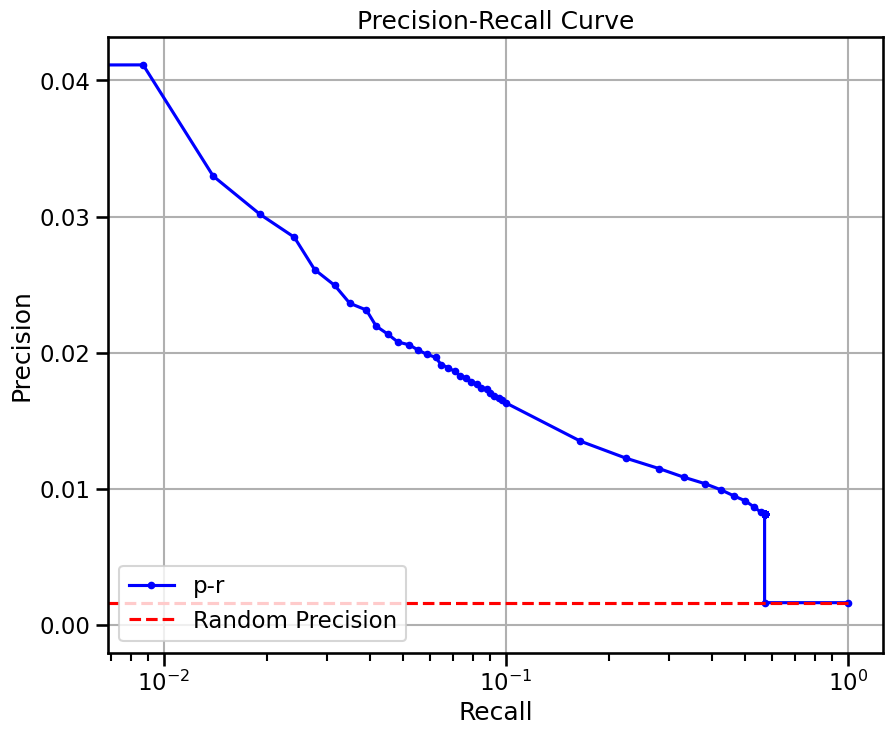

In [10]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
metrics['genie3_tf_perturb_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

In [11]:
metrics

{'genie3_perturb': {'precision': 0.021411638790563244,
  'recall': 0.9659762797288713,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.03565161597739377,
  'epr': 3.54075467253788},
 'genie3_perturb_base': {'TF_enr': True,
  'significant_enriched_TFtargets': 19.642857142857142,
  'precision': 0.0016940474499637448,
  'recall': 0.9264697414636955,
  'rand_precision': 0.0016326385571186594,
  'auprc': 0.0018857828449403108,
  'epr': 3.988476397763414},
 'genie3_tf_perturb': {'precision': 0.015117823033483179,
  'recall': 0.05607212414399698,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.020825095462878654,
  'epr': 1.0667829823965929},
 'genie3_tf_perturb_base': {'enriched_terms_Central': ['0__TFs',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Enteric neurons',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Tuft cells',
   'celltype.gmt__Satellite cells',
   'celltype.gmt__Radial glial cells'],
  'TF_enr': True,
  'significant_enriched_TFtargets': 5.3

In [12]:
import pandas as pd

In [13]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,perturb,3.540755,0.035652,0.020718,False
1,perturb,1.066783,0.020825,0.020718,True


In [14]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,perturb,3.988476,0.001886,0.001633,19.642857,True,False
1,perturb,17.297946,0.008183,0.001633,5.357143,True,True
